In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
%matplotlib inline

In [2]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
df = pd.read_csv('customer_data_internship.csv', encoding="ISO-8859-1")

In [4]:
df.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534561 entries, 0 to 534560
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    534561 non-null  object 
 1   StockCode    534561 non-null  object 
 2   Description  533112 non-null  object 
 3   Quantity     534561 non-null  int64  
 4   InvoiceDate  534561 non-null  object 
 5   UnitPrice    534561 non-null  float64
 6   CustomerID   402854 non-null  float64
 7   Country      534560 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.6+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,534561.0,9.570904,153.780087,-74215.00,1.00,3.00,10.00,74215.0
UnitPrice,534561.0,4.612396,97.331943,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,402854.0,15289.939809,1713.325217,12346.00,13959.00,15154.00,16791.00,18287.0


In [7]:
# Summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,534561,25655,573585,1114
StockCode,534561,4068,85123A,2294
Description,533112,4218,WHITE HANGING HEART T-LIGHT HOLDER,2358
InvoiceDate,534561,23047,10/31/2011 14:41,1114
Country,534560,38,United Kingdom,488716


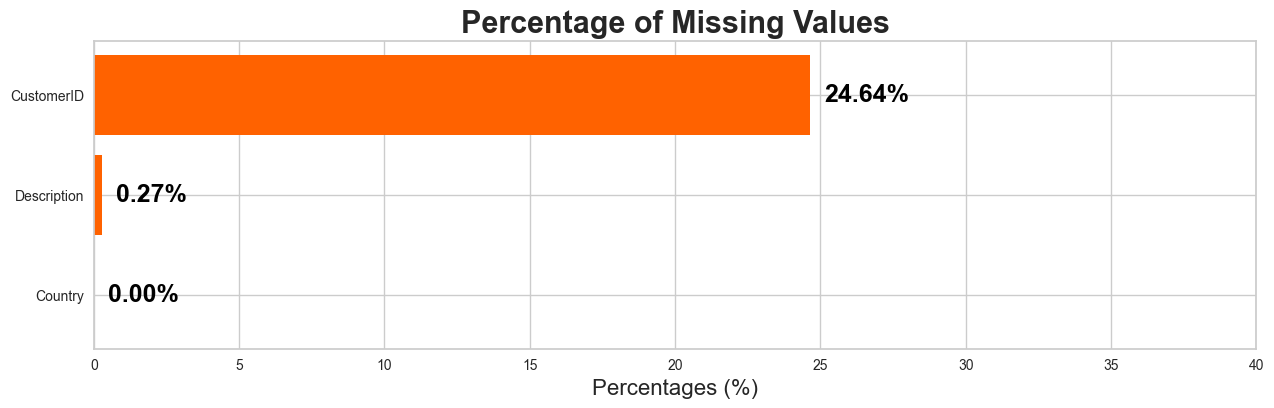

In [8]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100
# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [9]:
import pandas as pd
# Extracting rows with missing values in 'CustomerID' or 'Description' columns
missing_values_df = df[df['CustomerID'].isnull() | df['Description'].isnull()]

# Displaying the extracted DataFrame
print(missing_values_df)

       InvoiceNo StockCode                       Description  Quantity  \
622       536414     22139                               NaN        56   
1443      536544     21773   DECORATIVE ROSE BATHROOM BOTTLE         1   
1444      536544     21774   DECORATIVE CATS BATHROOM BOTTLE         2   
1445      536544     21786                POLKADOT RAIN HAT          4   
1446      536544     21787             RAIN PONCHO RETROSPOT         2   
...          ...       ...                               ...       ...   
533490    581023     85174                 S/4 CACTI CANDLES         1   
533491    581023       DOT                    DOTCOM POSTAGE         1   
533711    581102     21803                               NaN        20   
533712    581103     22689                               NaN         4   
534560    581150     21622  VINTAGE UNION JACK CUSHION COVER         1   

            InvoiceDate  UnitPrice  CustomerID         Country  
622     12/1/2010 11:52       0.00         NaN

In [10]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df = df.dropna(subset=['CustomerID', 'Description'])

In [12]:
# Verifying the removal of missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [13]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


In [14]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The dataset contains 5172 duplicate rows that need to be removed.


In [15]:
# Getting the number of rows in the dataframe
df.shape[0]

397682

In [16]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')
'''
C14245345  Cancelled
35365563   Completed
'''
# Analyze the characteristics of these rows (considering the new column)
# Calculate the number of completed and cancelled transactions
transaction_counts = df['Transaction_Status'].value_counts()

# Display the counts
print("Completed Transactions:", transaction_counts['Completed'])
print("Cancelled Transactions:", transaction_counts['Cancelled'])

Completed Transactions: 388887
Cancelled Transactions: 8795


In [17]:
# Group by 'Country' and 'Transaction_Status', then count the occurrences
transaction_counts_by_country = df.groupby(['Country', 'Transaction_Status']).size().unstack(fill_value=0)

# Display the counts
print(transaction_counts_by_country)

Transaction_Status    Cancelled  Completed
Country                                   
Australia                    74       1184
Austria                       3        391
Bahrain                       0         17
Belgium                      38       2014
Brazil                        0         32
Canada                        0        151
Channel Islands               9        747
Cyprus                        8        603
Czech Republic                5         25
Denmark                       9        380
EIRE                        247       7156
European Community            1         60
Finland                      10        685
France                      145       8289
Germany                     440       8835
Greece                        1        145
Iceland                       0        171
Israel                        2        245
Italy                        45        758
Japan                        37        321
Lebanon                       0         45
Lithuania  

In [75]:
transaction_counts_by_country = df.groupby(['Country', 'Transaction_Status']).size().unstack(fill_value=0)

# Reset the index for plotting
transaction_counts_by_country.reset_index(inplace=True)

# Create a new column indicating total transactions
transaction_counts_by_country['Total'] = transaction_counts_by_country['Cancelled'] + transaction_counts_by_country['Completed']

# Create a choropleth map figure
fig = go.Figure(data=go.Choropleth(
    locations=transaction_counts_by_country['Country'],  # ISO-3 country codes
    z=transaction_counts_by_country['Completed'],       # Completed transaction count
    locationmode='country names',                       # Set location mode to country names
    colorscale='Reds',                                  # Color scale for completed transactions
    colorbar_title='Completed Transactions',            # Title for color bar
    hovertext=transaction_counts_by_country.apply(lambda row: f"Cancelled: {row['Cancelled']}, Completed: {row['Completed']}", axis=1),
    hoverinfo='text',
))

# Update layout and add title
fig.update_layout(
    title_text='Completed Transactions by Country',
    geo=dict(
        showcoastlines=True,                             # Show country coastlines
    )
)

# Show the map
fig.show()

In [18]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed


In [19]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

# Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3683


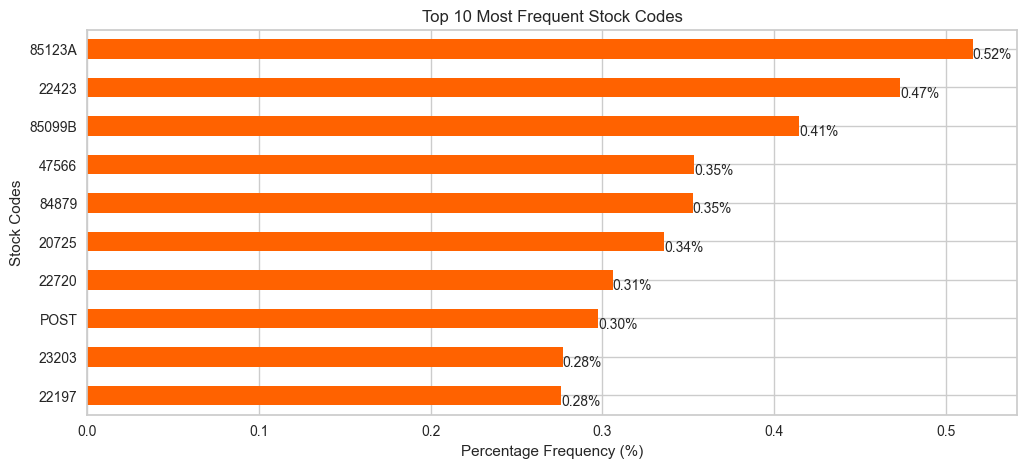

In [20]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100
# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [21]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3675
0       7
1       1
Name: count, dtype: int64


In [22]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
for code in anomalous_stock_codes:
    print(code)

POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [23]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


In [24]:
# Removing rows with anomalous stock codes from the dataset
df = df.drop(df[df['StockCode'].isin(anomalous_stock_codes)].index)

# Displaying the updated DataFrame
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
534555    581149     23099              FRENCH CARRIAGE LANTERN         1   
534556    581149     22365            DOORMAT RESPECTABLE HOUSE         1   
534557    581150     23084                   RABBIT NIGHT LIGHT         2   
534558    581150     23398                HANGING HEART BONHEUR         2   
534559    581150     23399        HOME SWEET HOME HANGING HEART         2   

            InvoiceDate  UnitPrice  CustomerID         Country  \
0        

In [25]:
df.shape[0]

395782

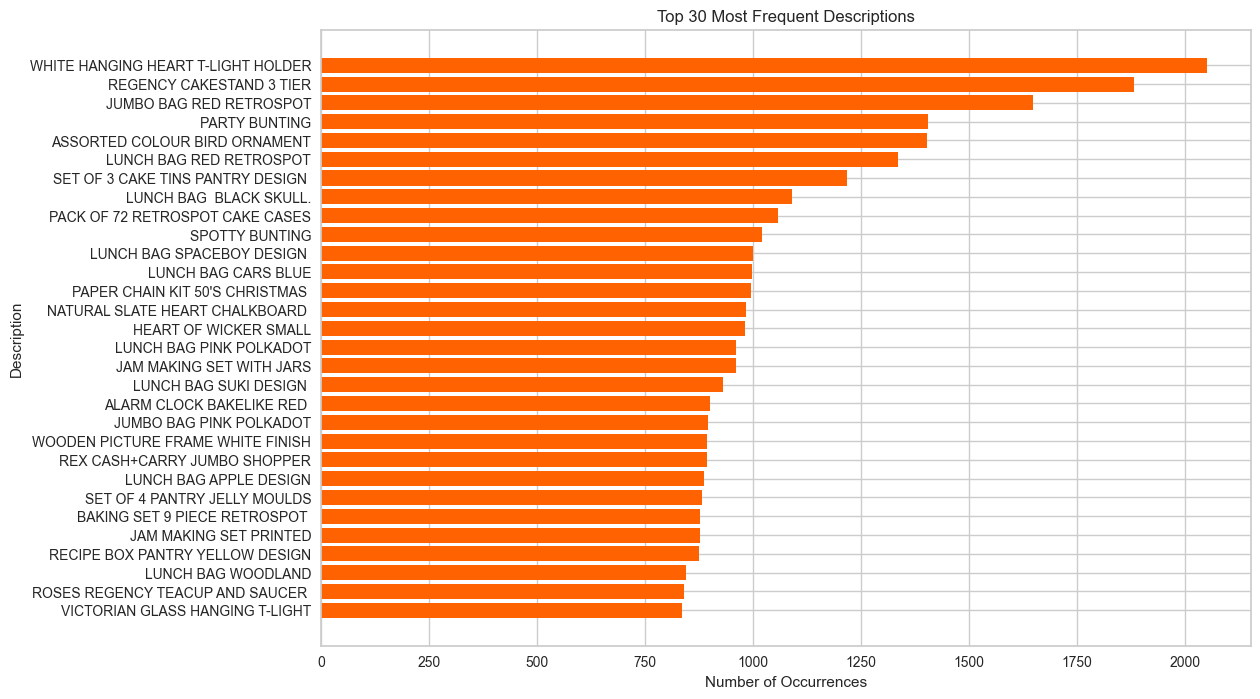

In [26]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()#value-count
# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [27]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
print(lowercase_descriptions)
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'LETTER "W" BLING KEY RING'
 'LETTER "Z" BLING KEY RING' 'PINK CRYSTAL SKULL PHONE CHARM']
The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [28]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [29]:
# Remove rows with service-related information in the description
df = df[~df['Description'].isin(service_related_descriptions)]
# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()
# Getting the number of rows in the dataframe
df.shape[0]

395701

In [30]:
df['UnitPrice'].describe()

count    395701.000000
mean          2.908575
std           4.462808
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [31]:
df[df['UnitPrice']==0].describe()['Quantity']

count       33.000000
mean       420.515152
std       2176.713608
min          1.000000
25%          2.000000
50%         11.000000
75%         36.000000
max      12540.000000
Name: Quantity, dtype: float64

In [32]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] != 0]

# Displaying the updated DataFrame
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
534555    581149     23099              FRENCH CARRIAGE LANTERN         1   
534556    581149     22365            DOORMAT RESPECTABLE HOUSE         1   
534557    581150     23084                   RABBIT NIGHT LIGHT         2   
534558    581150     23398                HANGING HEART BONHEUR         2   
534559    581150     23399        HOME SWEET HOME HANGING HEART         2   

            InvoiceDate  UnitPrice  CustomerID         Country  \
0        

In [34]:
# Convert InvoiceDate to datetime type
#extract date

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'],inplace=True)

In [35]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,323
1,12347.0,37
2,12348.0,73
3,12349.0,16
4,12350.0,308


In [36]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data=pd.merge(customer_data,total_transactions,on='CustomerID')
customer_data=pd.merge(customer_data,total_products_purchased,on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.sample(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
761,13354.0,69,1,604
4069,17893.0,223,1,149
2803,16152.0,266,1,642
3253,16764.0,1,18,1241
2647,15942.0,131,1,232
1896,14924.0,243,1,64
2999,16416.0,24,4,656
1933,14978.0,70,5,523
3083,16531.0,20,7,915
4082,17911.0,7,1,223


In [37]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.sample(5)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
2646,15940.0,309,1,4,35.80,35.80000
3498,17097.0,8,8,365,793.77,99.22125
2585,15847.0,36,2,449,389.27,194.63500
1683,14631.0,48,3,622,1006.98,335.66000
471,12951.0,6,8,500,1042.07,130.25875


In [39]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased=df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode':'Unique_Products_Purchased'},inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,323,2,0,0.00,0.000000,1
1,12347.0,37,6,2266,4085.18,680.863333,100
2,12348.0,73,4,2332,1437.24,359.310000,21
3,12349.0,16,1,630,1457.55,1457.550000,72
4,12350.0,308,1,196,294.40,294.400000,16


In [40]:
customer_data.sample(15)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
837,13470.0,97,2,100,165.00,82.500000,7
4037,17856.0,231,5,561,1118.39,223.678000,6
3300,16824.0,13,2,236,460.64,230.320000,23
3766,17483.0,63,3,191,414.04,138.013333,18
2811,16163.0,223,3,92,441.60,147.200000,5
4285,18191.0,259,1,140,207.80,207.800000,7
2675,15984.0,0,11,1805,2759.93,250.902727,217
1577,14488.0,49,2,793,1047.43,523.715000,46
2330,15511.0,9,5,269,900.53,180.106000,117
3337,16878.0,22,2,0,0.00,0.000000,3


In [41]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data=pd.merge(customer_data,average_days_between_purchases,on='CustomerID')
customer_data=pd.merge(customer_data,favorite_shopping_day,on='CustomerID')
customer_data=pd.merge(customer_data,favorite_shopping_hour,on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,323,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,37,6,2266,4085.18,680.863333,100,1.929412,1,14
2,12348.0,73,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,16,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,308,1,196,294.40,294.400000,16,0.000000,2,16


In [42]:
df['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.891346
Germany           0.022448
France            0.020505
EIRE              0.018440
Spain             0.006088
Name: proportion, dtype: float64

In [43]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.sample(5)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
2200,15376.0,38,3,615,1221.56,407.186667,100,1.582609,6,13,1
4115,18065.0,3,15,1024,2380.08,158.672000,110,2.620438,2,11,1
211,12609.0,76,3,639,964.85,321.616667,56,4.285714,0,15,0
4209,18196.0,93,2,431,686.63,343.315000,131,1.413043,1,16,1
92,12457.0,56,11,686,1597.78,145.252727,52,2.873016,2,15,0


In [44]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

Is_UK
1    3861
0     415
Name: count, dtype: int64

In [45]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)
#no. of cancellations per customer
# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0,inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate']=customer_data['Cancellation_Frequency']/total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.sample(5)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
789,13419.0,61,1,275,221.06,221.060000,16,0.000000,4,12,1,0.0,0.0
3491,17179.0,176,3,290,711.79,237.263333,56,2.316456,3,16,1,0.0,0.0
488,12985.0,26,1,841,754.38,754.380000,52,0.000000,4,12,1,0.0,0.0
2451,15722.0,33,6,1018,2169.86,361.643333,47,3.695652,1,11,1,1.0,0.2
1502,14419.0,8,6,483,1051.79,175.298333,112,1.761194,1,11,1,0.0,0.0


In [46]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()
#print(monthly_spending)
#Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)
#The calculated slope represents the rate of change in spending over time. 
# #Positive slopes indicate increasing spending trends, while negative slopes suggest decreasing trends.

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.sample(5)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
4104,18045.0,43,1,138,178.34,178.340,43,0.000000,1,13,1,0.0,0.0,178.340,0.000000,0.000
2400,15653.0,90,2,1200,877.44,438.720,4,4.600000,1,9,1,0.0,0.0,438.720,552.561523,781.440
1416,14293.0,1,4,709,1046.56,261.640,51,6.083333,0,15,1,0.0,0.0,261.640,96.098409,-8.502
1289,14116.0,17,5,707,1382.74,276.548,61,1.436620,3,13,1,0.0,0.0,345.685,54.360074,33.790
213,12611.0,50,1,846,1193.32,1193.320,65,0.000000,1,13,0,0.0,0.0,1193.320,0.000000,0.000


In [47]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [48]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,323,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,37,6,2266,4085.18,680.863333,100,1.929412,1,14,0,0,0.0,680.863333,322.400672,85.356571
2,12348.0,73,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,16,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,308,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
5,12352.0,34,8,463,1265.41,158.17625,57,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351
6,12353.0,202,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
7,12354.0,230,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
8,12355.0,212,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
9,12356.0,20,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635


In [49]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4276 entries, 0 to 4275
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4276 non-null   string 
 1   Days_Since_Last_Purchase        4276 non-null   Int64  
 2   Total_Transactions              4276 non-null   Int64  
 3   Total_Products_Purchased        4276 non-null   Int64  
 4   Total_Spend                     4276 non-null   Float64
 5   Average_Transaction_Value       4276 non-null   Float64
 6   Unique_Products_Purchased       4276 non-null   Int64  
 7   Average_Days_Between_Purchases  4276 non-null   Float64
 8   Day_Of_Week                     4276 non-null   Int32  
 9   Hour                            4276 non-null   Int32  
 10  Is_UK                           4276 non-null   Int64  
 11  Cancellation_Frequency          4276 non-null   Int64  
 12  Cancellation_Rate               42

In [50]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,323,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,37,6,2266,4085.18,680.863333,100,1.929412,1,14,0,0,0.0,680.863333,322.400672,85.356571,1,0
2,12348.0,73,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,16,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,308,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


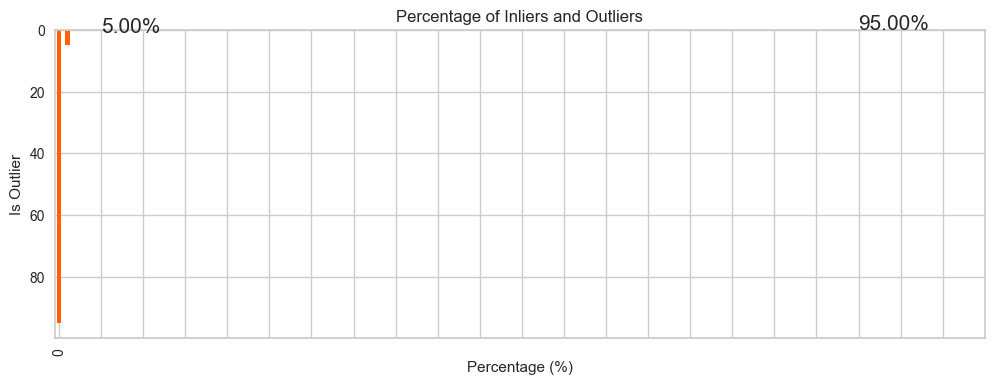

In [51]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12,4))
outlier_percentage.plot(kind='bar',color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [52]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)
print(customer_data_cleaned.tail(5))

     CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
4057    18280.0                       275                   1   
4058    18281.0                       178                   1   
4059    18282.0                         5                   3   
4060    18283.0                         1                  16   
4061    18287.0                        40                   3   

      Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
4057                        45        180.6                      180.6   
4058                        54        80.82                      80.82   
4059                        98        176.6                  58.866667   
4060                      1355      2039.58                  127.47375   
4061                      1586      1837.28                 612.426667   

      Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
4057                         10                             0.0            0   
4058

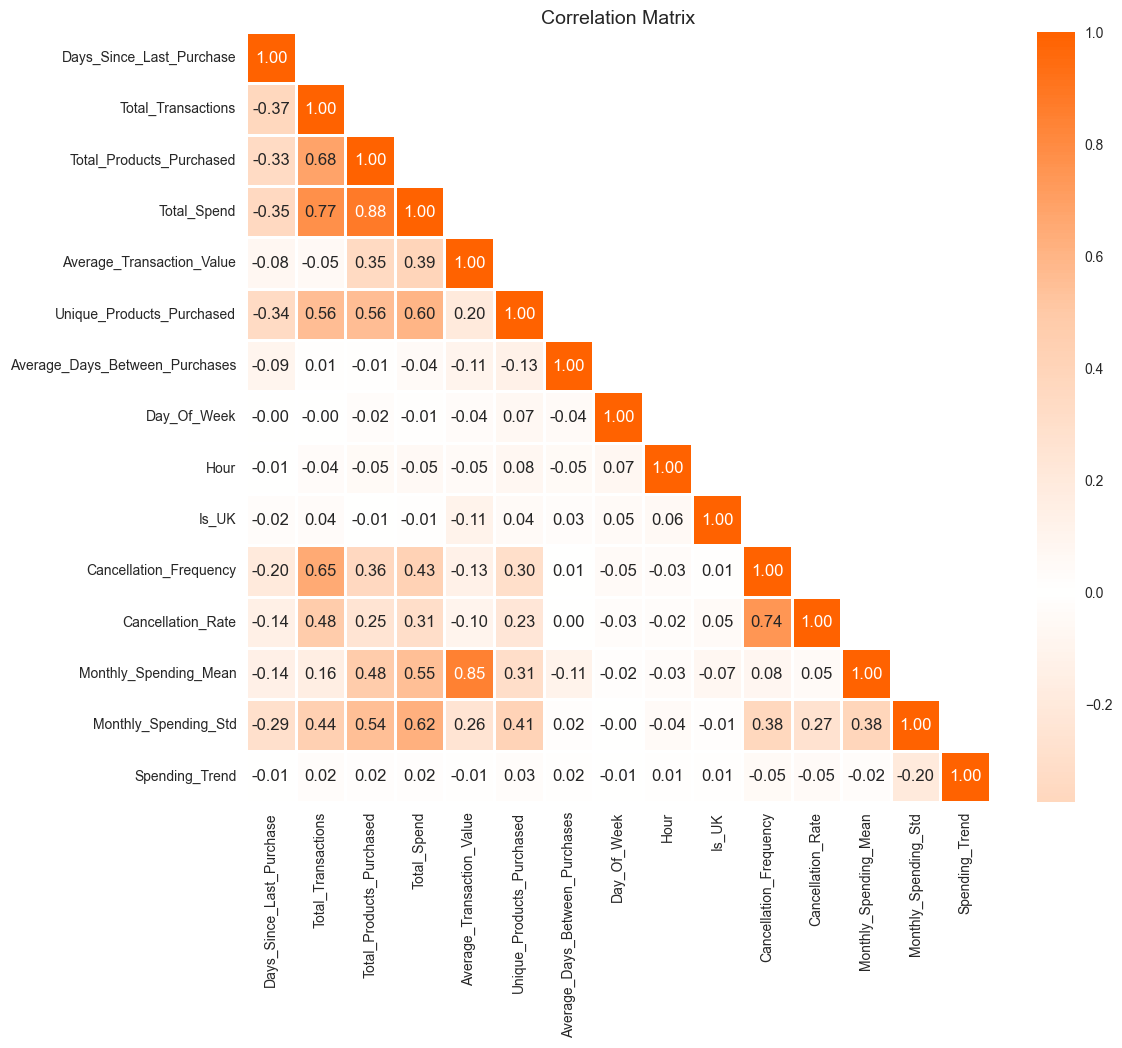

In [54]:
# Reset background style

sns.set_style('whitegrid')

#Calculate the correlation matrix excluding the 'CustomerID' column 
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

#Define a custom colormap

colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']

my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the Lower triangle of the matrix (since it's mirrored around its

#top-left to bottom-right diagonal)

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask, k=1)] = True

#Plot the heatmap

plt.figure(figsize=(12, 10))

sns.heatmap(corr, mask=mask, cmap=my_cmap, annot= True, center=0, fmt='.2f', linewidths=2)

plt.title('Correlation Matrix', fontsize=14)

plt.show()

In [55]:
# Initialize the StandardScaler 
scaler = StandardScaler()

# List of columns that don't need to be scaled 
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled

columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset

customer_data_scaled = customer_data_cleaned.copy()

print(customer_data_scaled.head())

# Applying the scaler to the necessary columns in the dataset

customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data

print(customer_data_scaled.head())

  CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0    12346.0                       323                   2   
1    12347.0                        37                   6   
2    12348.0                        73                   4   
3    12349.0                        16                   1   
4    12350.0                       308                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         0          0.0                        0.0   
1                      2266      4085.18                 680.863333   
2                      2332      1437.24                     359.31   
3                       630      1457.55                    1457.55   
4                       196        294.4                      294.4   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                          1                             0.0            1   
1                        100                  

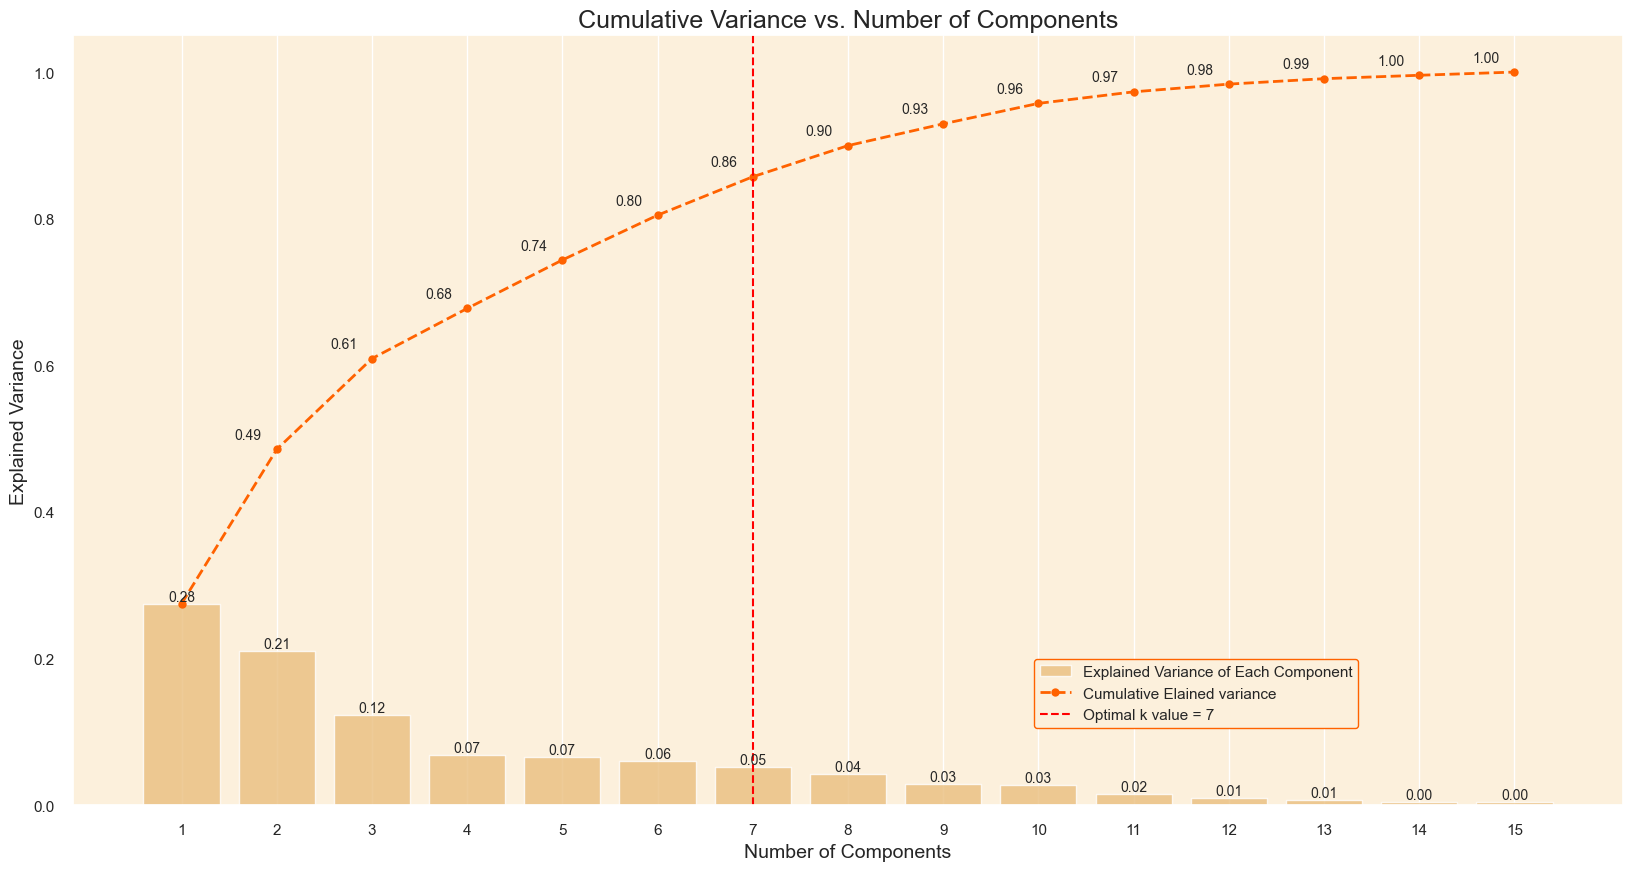

In [58]:
# Setting CustomerID as the index column

customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA

pca = PCA().fit(customer_data_scaled)

#Calculate the Cumulative Sum of the Explained Variance

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum (explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)

optimal_k = 7

# Set seaborn plot style 
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of compoints 
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)), y=explained_variance_ratio, color='#fcc36d', alpha=0.8)

#Line plot for the cumulative explained variance

lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance, marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value Line

optimal_k_line= plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set Labels and title

plt.xlabel('Number of Components', fontsize=14)

plt.ylabel('Explained Variance', fontsize=14) 
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

#Customize ticks and Legend

plt.xticks(range(0, len(cumulative_explained_variance)))

plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],

labels = ['Explained Variance of Each Component', 'Cumulative Elained variance', f'Optimal k value = {optimal_k}'], loc =(0.62, 0.1),

frameon = True, framealpha=1.0, edgecolor='#ff6200')

#Display the variance values for both graphs on the plots

x_offset = -0.3
y_offset = 0.01
for i,(ev_ratio,cum_ev_ratio) in enumerate(zip(explained_variance_ratio,cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom",fontsize=10)
    if i > 0:
        plt.text(i + x_offset,cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}",ha="center",va="bottom",fontsize=10)
plt.grid(axis='both')
plt.show()


In [60]:
# Creating a PCA object with 6 components 
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe 
customer_data_pca = pca.fit_transform(customer_data_scaled)

#Creating a new dataframe from the PCA dataframe, with columns Labeled PC1, PC2, etc. 
customer_data_pca = pd.DataFrame (customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

#Adding the CustomerID index back to the new PCA dataframe

customer_data_pca.index= customer_data_scaled.index


In [61]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.158445,-1.733703,-1.537019,1.089845,-0.420030,-1.598474
12347.0,3.143664,-1.356905,2.263951,-1.030922,-0.202132,0.428990
12348.0,0.652554,0.592866,0.664271,-0.659731,-0.364927,2.349447
12349.0,1.741021,-2.648326,5.586742,0.765007,0.496067,-1.562665
12350.0,-1.992659,-0.570082,0.529687,0.349295,-1.489875,0.201780


In [62]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.217174,-0.017196,0.060496,0.332746,-0.248031,-0.337381
Total_Transactions,0.380169,0.021560,-0.267016,-0.129660,-0.019006,-0.035439
Total_Products_Purchased,0.402525,0.012430,0.088187,-0.127687,0.048542,-0.018172
Total_Spend,0.433247,0.017595,0.083726,-0.085448,0.023121,-0.038606
Average_Transaction_Value,0.177293,-0.012107,0.577659,0.115242,0.007685,-0.099225
Unique_Products_Purchased,0.325762,0.066578,0.012872,-0.209357,-0.191000,0.136125
Average_Days_Between_Purchases,-0.022094,-0.034450,-0.123696,-0.205303,0.743067,0.160198
Day_Of_Week,-0.043774,0.994544,-0.004638,0.029842,0.056535,-0.056825
Hour,-0.022509,0.056611,-0.013009,-0.202989,-0.511321,0.658683
Is_UK,-0.000863,0.007486,-0.020171,-0.014776,-0.005528,0.015617


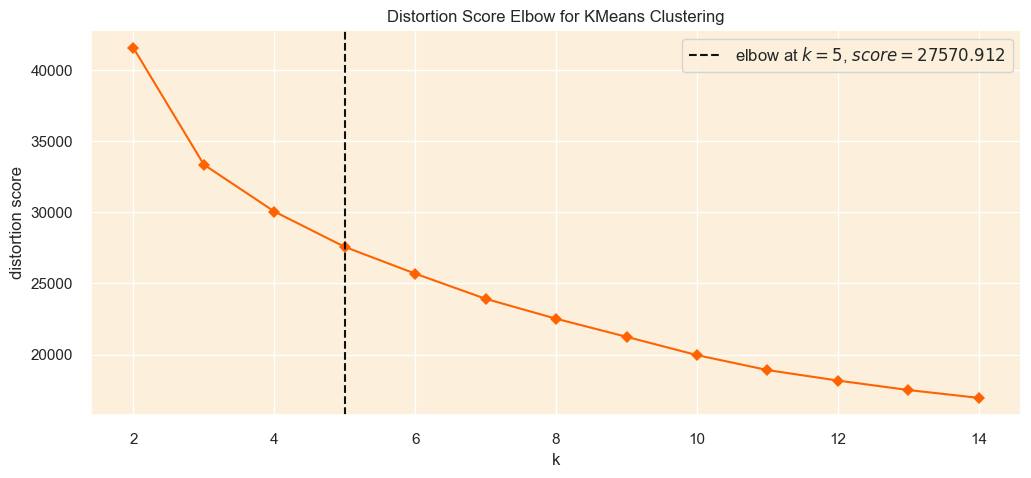

In [63]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

In [64]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

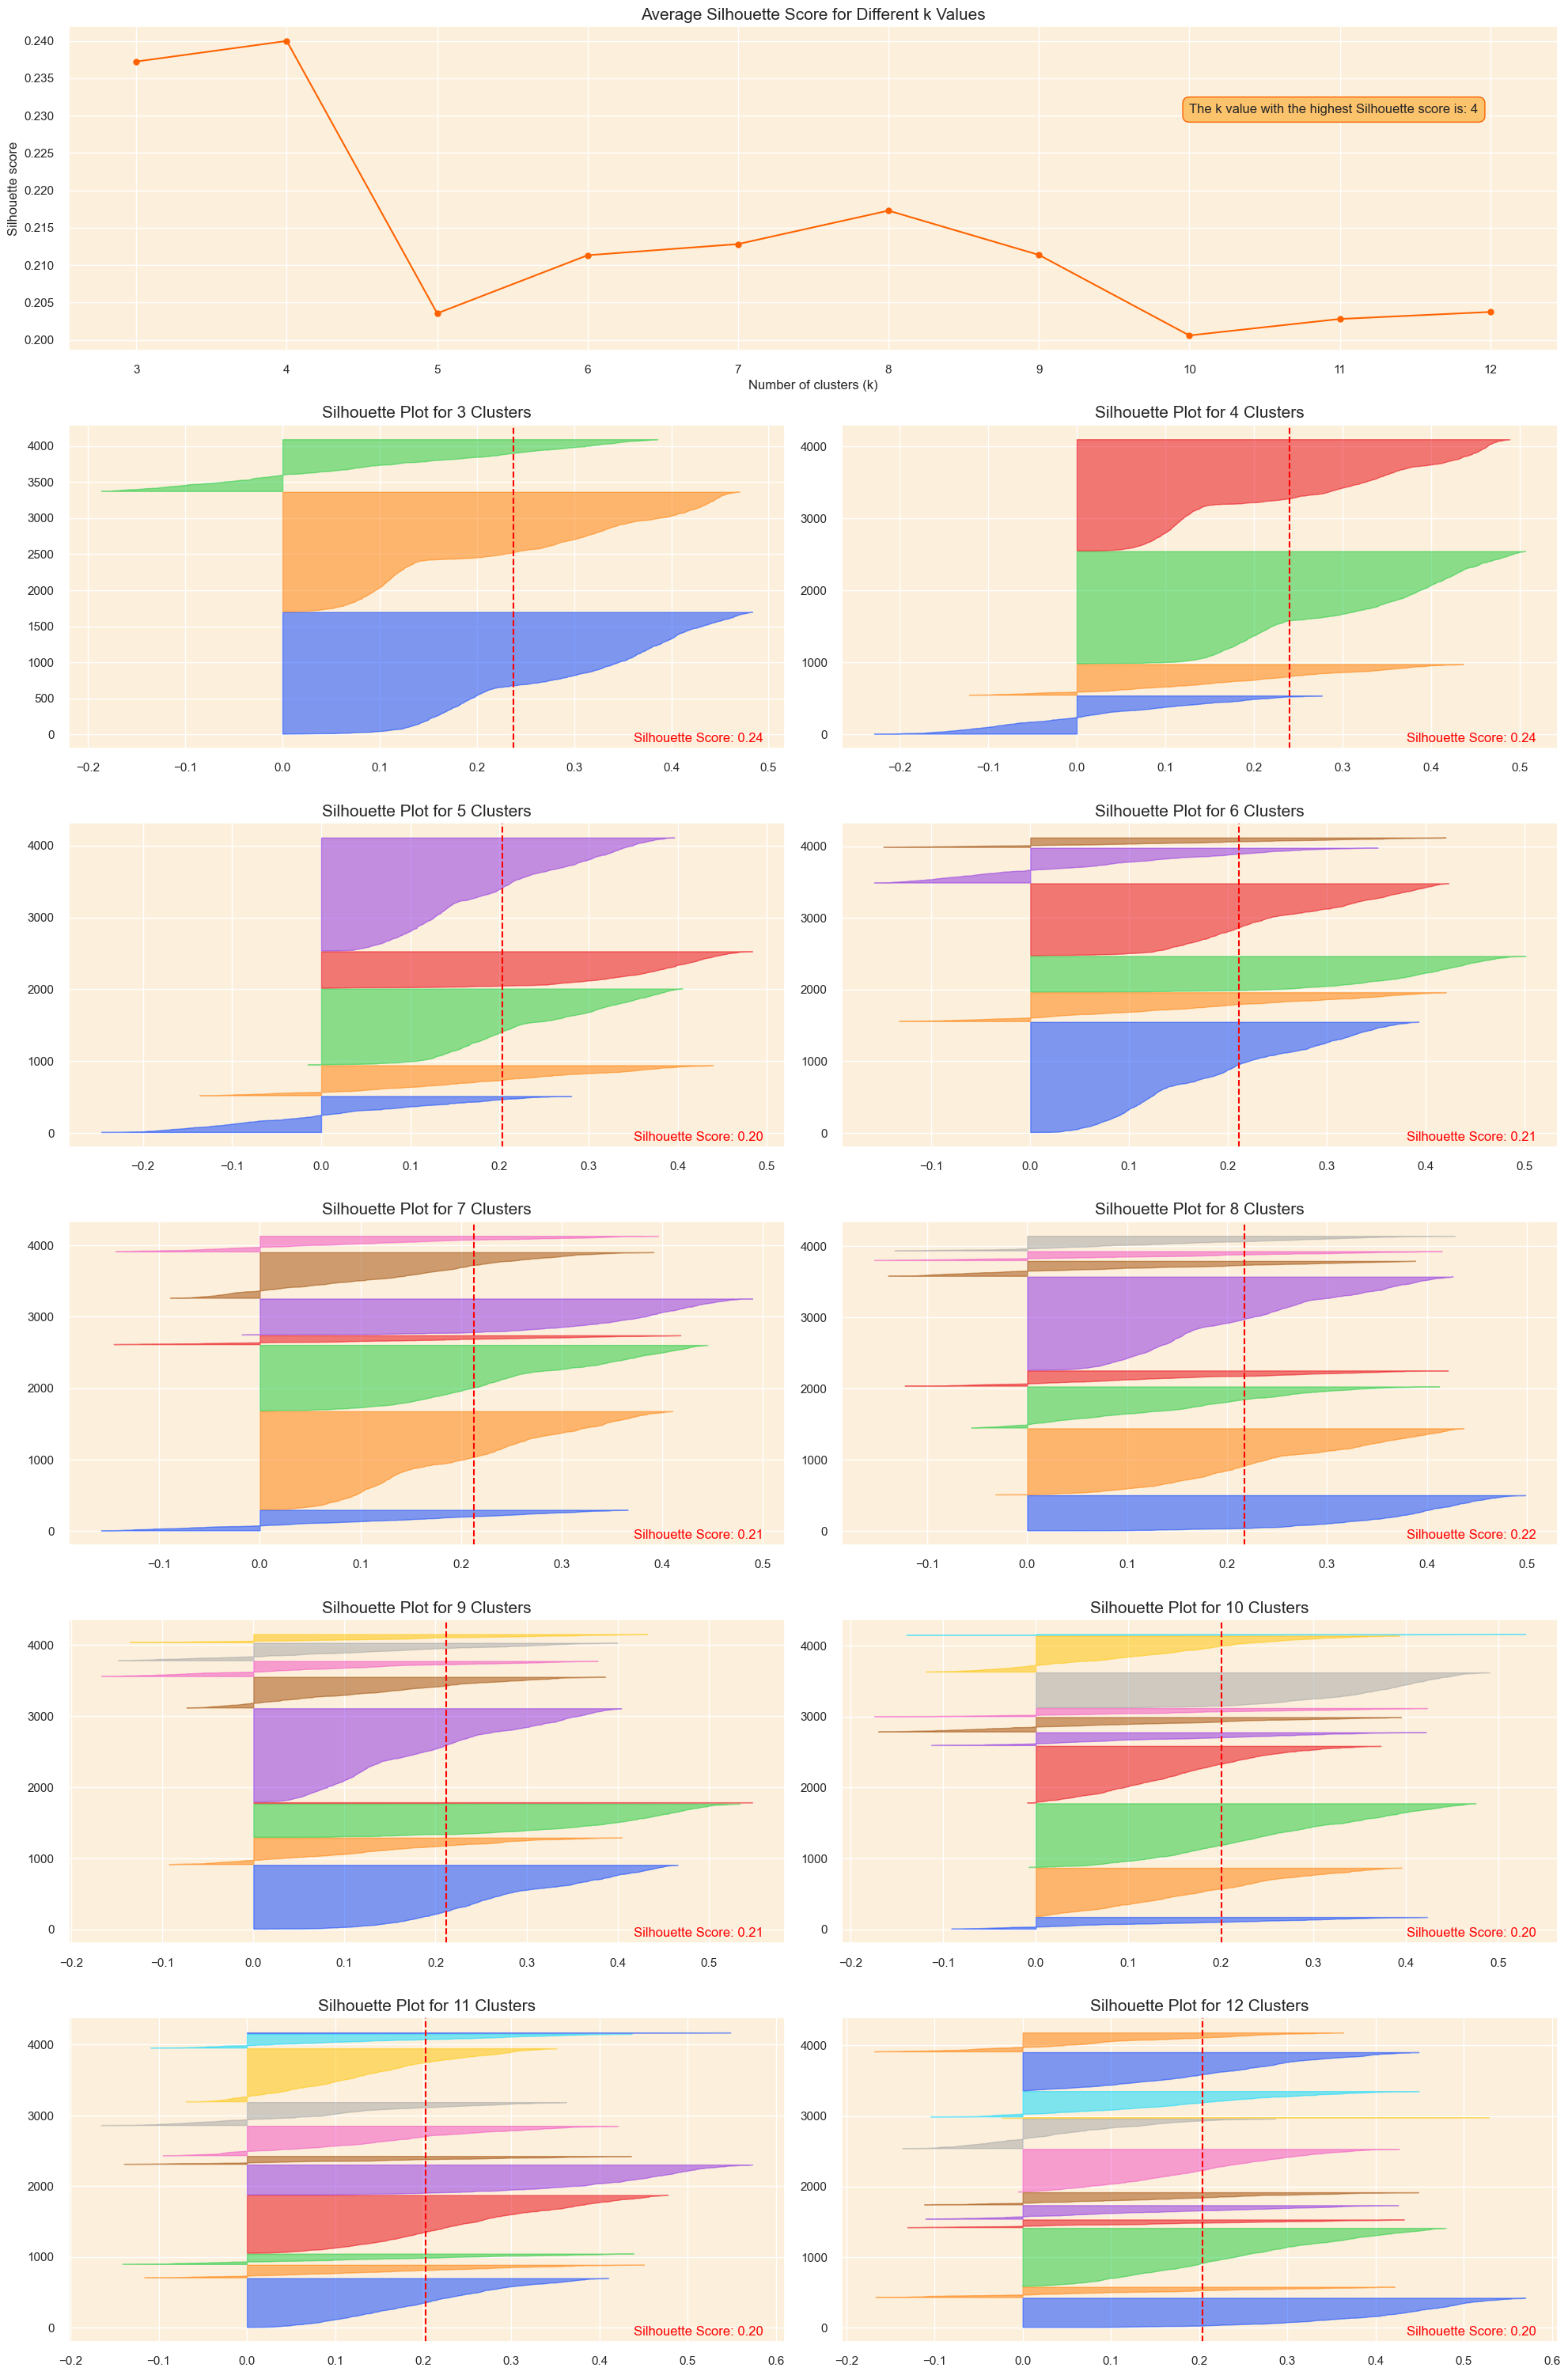

In [65]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

In [66]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [67]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,323,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1
1,12347.0,37,6,2266,4085.18,680.863333,100,1.929412,1,14,0,0,0.0,680.863333,322.400672,85.356571,0
2,12348.0,73,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,2
3,12349.0,16,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1
4,12350.0,308,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1


In [68]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

In [69]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

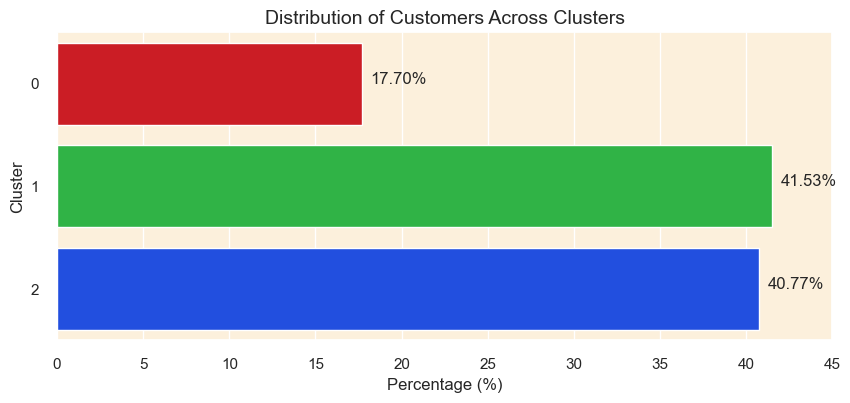

In [70]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

In [71]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4062         |
|    Silhouette Score     | 0.23722324562309763 |
| Calinski Harabasz Score |  1260.36783662468   |
|  Davies Bouldin Score   |  1.365312091253548  |
+-------------------------+---------------------+


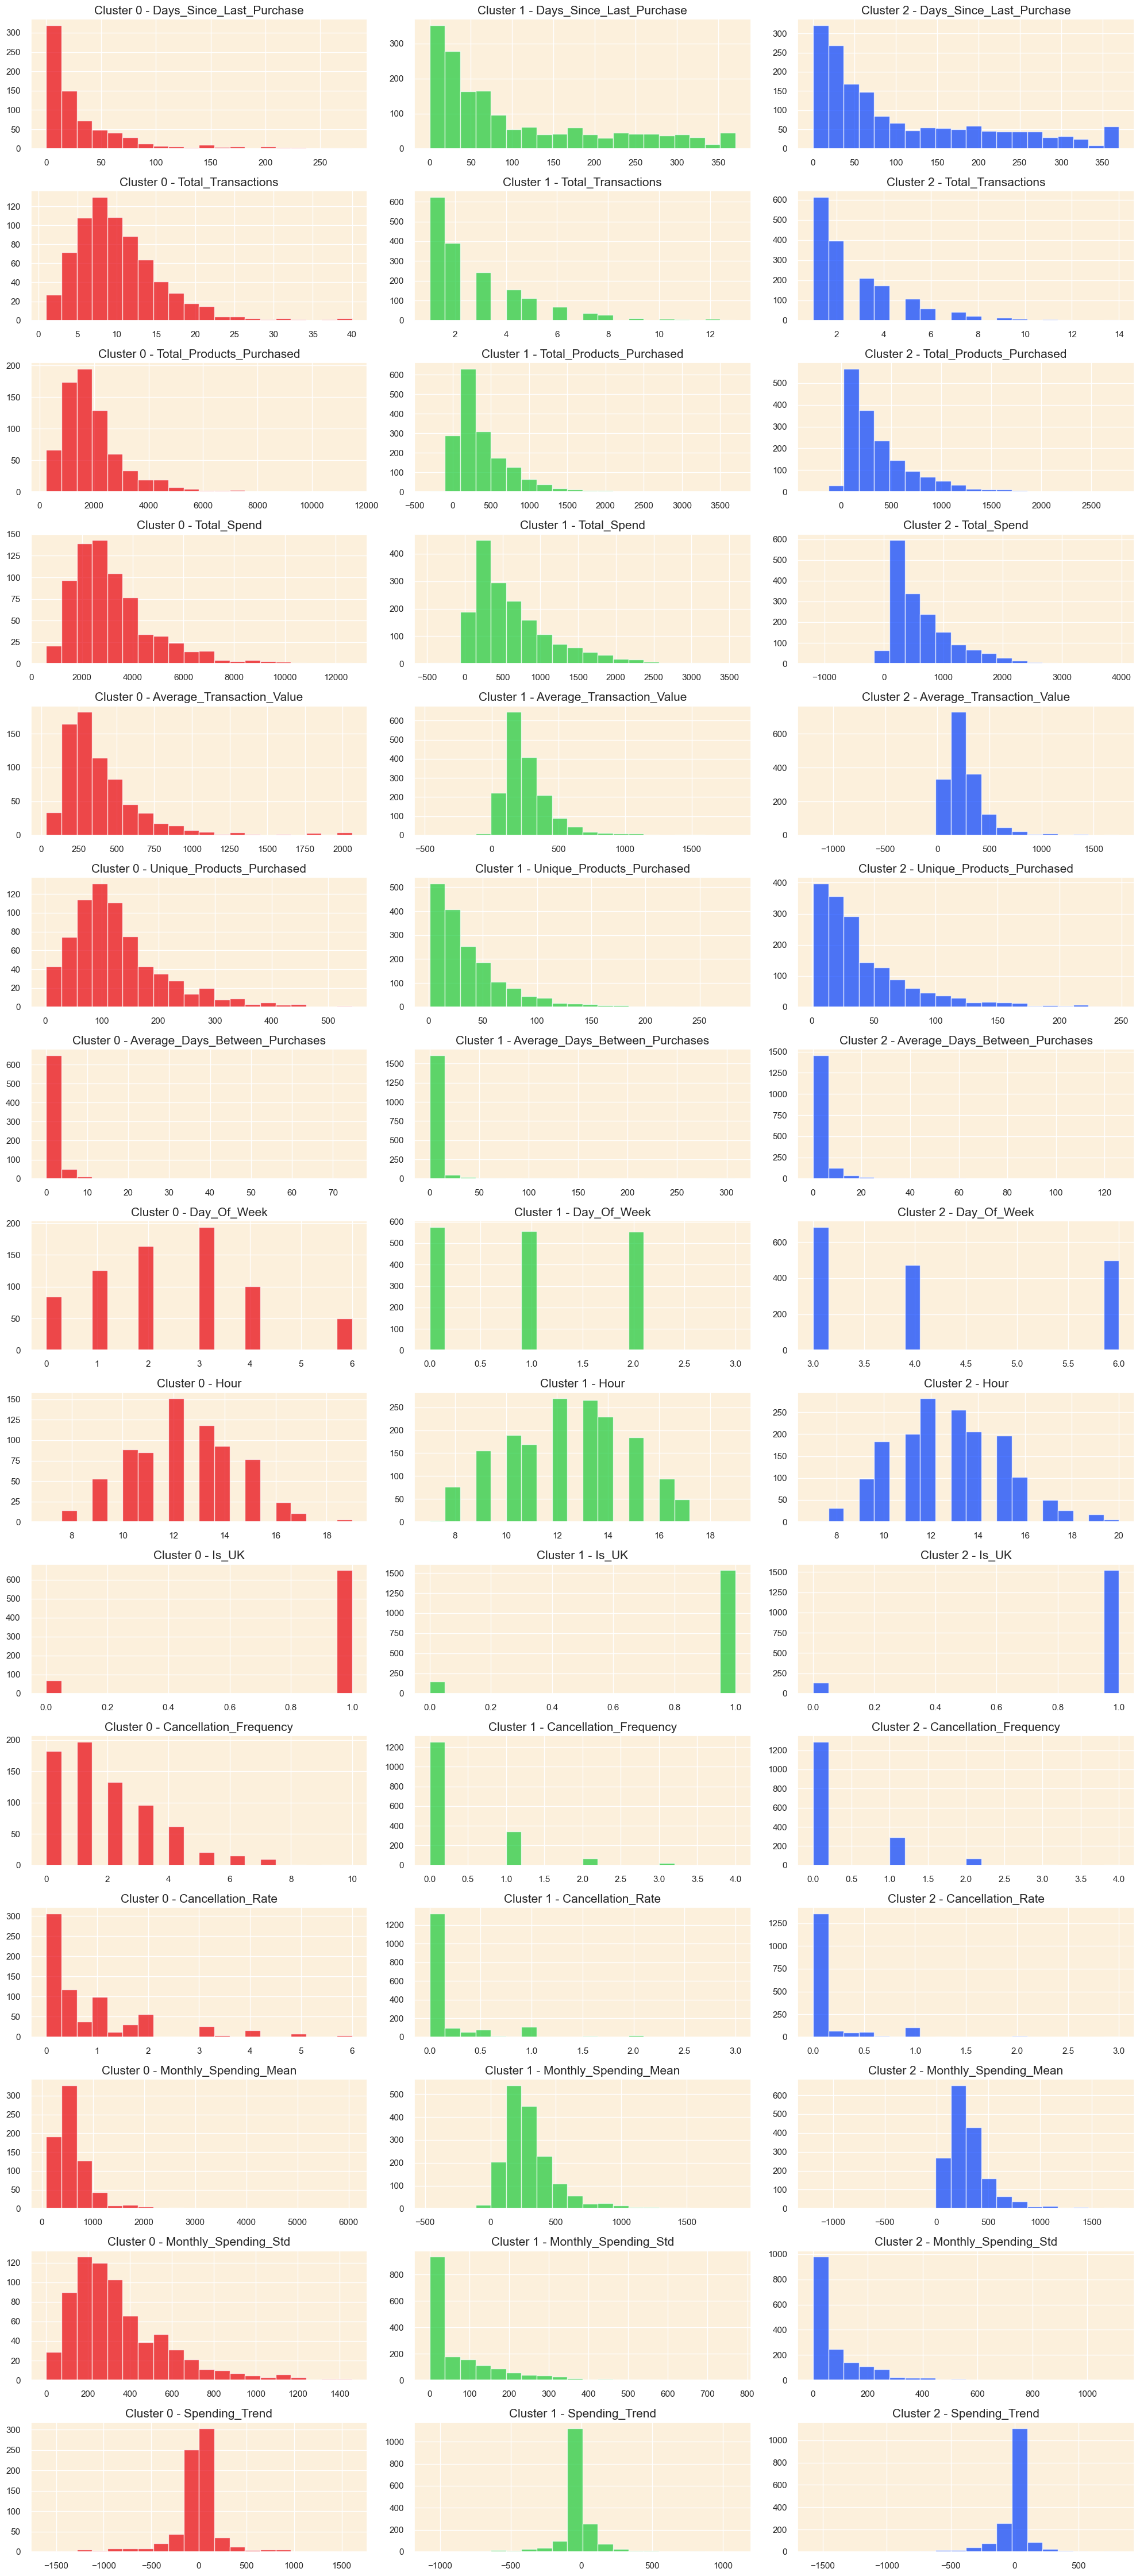

In [72]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

In [73]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [74]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
17647.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
15773.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
17711.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
14757.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,15036,ASSORTED COLOURS SILK FAN,85123A,WHITE HANGING HEART T-LIGHT HOLDER
16905.0,22616,PACK OF 12 LONDON TISSUES,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT
16678.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT,84879,ASSORTED COLOUR BIRD ORNAMENT
13960.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
15411.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
13329.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
